# Imports

In [1]:
import numpy as np
import json
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf

# Data preprocessing

In [2]:
IMG_DIR = "Images"
JSON = "StanfordExtra_V12/StanfordExtra_v12.json"
KEYPOINT_DEF = (
    "https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv"
)

with open(JSON) as infile:
    json_data = json.load(infile)

json_dict = {'Images/'+i["img_path"]: i for i in json_data}

In [3]:
json_dict

{'Images/n02085782-Japanese_spaniel/n02085782_2886.jpg': {'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
  'img_width': 350,
  'img_height': 272,
  'img_bbox': [205, 20, 116, 201],
  'is_multiple_dogs': False,
  'joints': [[108.66666666666667, 252.0, 1],
   [147.66666666666666, 229.0, 1],
   [163.5, 208.5, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [54.0, 244.0, 1],
   [77.33333333333333, 225.33333333333334, 1],
   [79.0, 196.5, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [150.66666666666666, 86.66666666666667, 1],
   [88.66666666666667, 73.0, 1],
   [116.0, 106.33333333333333, 1],
   [109.0, 123.33333333333333, 1],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0],
   [0, 0, 0]],
  'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TO

In [4]:
image_path = 'n02085782-Japanese_spaniel/n02085782_2886.jpg'

def draw_key_points(path: str):
    '''
    Draw the keypoints of an image
    '''
    # path = path.decode('utf-8').replace('\\', '/')
    img = cv.imread(str(path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 

    kp = json_dict[path]['joints']

    for p in kp:
        x,y = int(p[0]), int(p[1])
        cv.circle(img, (x,y), 2, (0,0,255), 2)

    plt.imshow(img)

    return img, kp

In [5]:
from sklearn.model_selection import train_test_split

imgs = [i for i in json_dict]

X_train, X_test = train_test_split(imgs, test_size=.1)
X_test, X_val = train_test_split(X_test, test_size=.5)

In [6]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

11284
627
627


### some checks on the data

In [7]:
#ensure all the keypoints has the same length
s = set()
for i in json_dict:
    s.add(len(json_dict[i]['joints']))

s

{24}

In [8]:
#return last value of all kp
s = set()
for i in json_dict:
    for j in range(24):
        s.add(json_dict[i]['joints'][j][2])

s

{0, 1}

this mean that for each image we should predict 24 joint

### utility functions/classes

In [9]:
from dataclasses import dataclass

@dataclass
class Args:
    image_size: int = 224
    num_augmentations_per_image: int = 1
    batch_size: int = 16
    n_classes: int = 24
    augmantation_factor: int = 3
    sigma: float = 2.0

args = Args()

In [10]:
def verify_augmantation(img, kp, proba):
    """
    plot the given key points on the given img
    """
    # img, kp = x[0].numpy(), x[1].numpy()
    joints = np.reshape(kp, (24, 2))
    # plt.imshow(img)
    j = 0
    for kp in joints:
        if proba[j]:
            x,y = int(kp[0]), int(kp[1])
            cv.circle(img, (x,y), 2, (0,0,255), 2)
        j += 2
    plt.imshow(img)


In [11]:
from scipy.ndimage import gaussian_filter

def generate_heatmap(joints):

    image_shape = (args.image_size, args.image_size)
    heat_maps = []

    for kp in joints:
        if np.isnan(kp[0]) or np.isnan(kp[1]):
            kp = [0, 0]
            
        heat_map = np.zeros(image_shape)
        x, y = int(kp[0]), int(kp[1])
        if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
            heat_map[y, x] = 1
            heat_map = gaussian_filter(heat_map, sigma=args.sigma)
            heat_map = heat_map / heat_map.max()

        heat_maps.append(heat_map)

    return np.stack(heat_maps, axis=-1)

In [12]:
import albumentations  as A

def train_augmantation(img, kp, proba):

    transform = A.Compose([
        A.Resize(width=args.image_size, height=args.image_size, p=1),
        A.VerticalFlip(p=.3),
        A.Rotate(p=0.2),
        A.OneOf([
                A.HueSaturationValue(p=0.5), 
                A.RGBShift(p=0.7)
            ], p=.6),
        A.RandomBrightnessContrast(p=0.4),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    transformed = transform(image=img, keypoints=kp)
    
    return transformed['image'], generate_heatmap(transformed['keypoints'])

def test_val_augmantation(img, kp, proba):

    transform = A.Compose([
        A.Resize(width=args.image_size, height=args.image_size, p=1)
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    transformed = transform(image=img, keypoints=kp)
    
    # verify_augmantation(transformed['image'], transformed['keypoints'], proba)

    return transformed['image'], generate_heatmap(transformed['keypoints'])

In [14]:
def preprocess(path, train: bool=True):
    img = cv.imread(str(path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    kp = []
    proba =  []
    for p in json_dict[path]['joints']:
        kp.append([p[0], p[1]])
        proba.append(p[2])
        proba.append(p[2])

    if train:
        return train_augmantation(img, kp, proba)
    
    return test_val_augmantation(img, kp, proba)

In [15]:
import os

def train_generator():
    for p in X_train:
        yield preprocess(p)

output_shapes = (tf.TensorShape([None, None, None]), tf.TensorShape([None, None, None]))
output_types = (tf.float32, tf.float32)

train_ds = tf.data.Dataset.from_generator(train_generator, output_types=output_types, output_shapes=output_shapes)\
                          .batch(args.batch_size).repeat()

def test_generator():
    for p in X_test:
        yield preprocess(p, train=False)


test_ds = tf.data.Dataset.from_generator(test_generator, output_types=output_types, output_shapes=output_shapes)\
                          .batch(args.batch_size)

def val_generator():
    for p in X_val:
        yield preprocess(p, train=False)

val_ds = tf.data.Dataset.from_generator(val_generator, output_types=output_types, output_shapes=output_shapes)\
                          .batch(args.batch_size)


In [51]:
iterator = iter(val_ds)

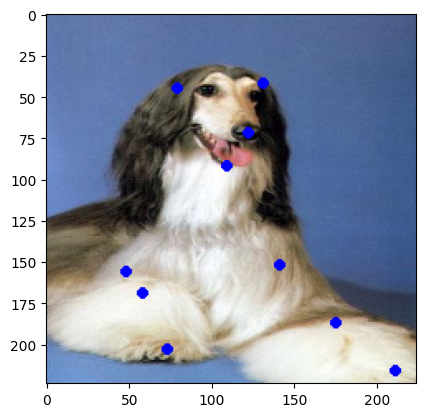

In [52]:
img, heatmap = next(iterator)

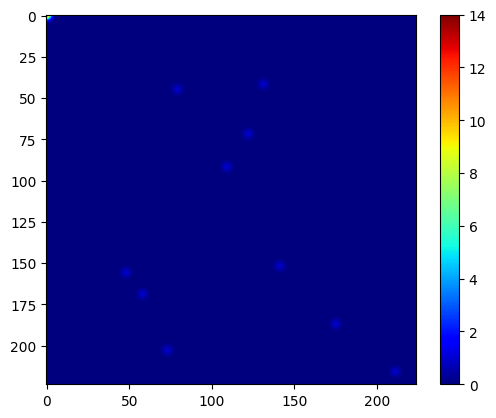

In [53]:
plt.imshow(np.sum(heatmap.numpy().squeeze(), axis=-1), cmap='jet')
plt.colorbar()
plt.show()

In [31]:
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Concatenate, Dropout

def conv_block(x: tf.Tensor, units: int, kernel_size: int= 3, pool: bool= True, drop_out: bool= True):

    x = Conv2D(units, kernel_size, padding='same')(x)
    x = Conv2D(units, kernel_size, padding='same')(x)
    
    if drop_out:
        x = Dropout(rate=.1)(x)

    if pool:
        pool = MaxPool2D()(x)
    else:
        pool = x

    return pool, x

def deconv_block(x: tf.Tensor, residual: tf.Tensor, units: int, kernel_size: int= 3):

    x = Conv2DTranspose(units, kernel_size, strides=(2,2), padding='same')(x)
    x = Concatenate()([x, residual])

    x = Conv2D(units, kernel_size=kernel_size, padding='same')(x)
    x = Conv2D(units, kernel_size=kernel_size, padding='same')(x)

    return x

In [74]:
from keras.layers import Input
from keras import Model

units = 16

inputs = Input(shape=(args.image_size, args.image_size, 3))

conv1, res1 = conv_block(inputs, units, 3)
conv2, res2 = conv_block(conv1, units*2, 3)
conv3, res3 = conv_block(conv2, units*3, 3)
conv4, res4 = conv_block(conv3, units*4, 3)

conv5, _ = conv_block(conv4, units*5, 3, pool=False, drop_out=False)

x = deconv_block(conv5, res4, units*4)
x = deconv_block(x, res3, units*3)
x = deconv_block(x, res2, units*2)
x = deconv_block(x, res1, units)

outputs = Conv2D(args.n_classes, kernel_size=(1,1), activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 224, 224, 16  448         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_78 (Conv2D)             (None, 224, 224, 16  2320        ['conv2d_77[0][0]']              
                                )                                                           

In [75]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1, monitor='val_loss')

In [76]:
steps  = (len(X_train)//args.batch_size) * args.augmantation_factor

model.fit(train_ds, epochs=6, validation_data=val_ds, steps_per_epoch=steps, callbacks=[es])

Epoch 1/6


2115/2115 [==============================] - 1235s 583ms/step - loss: 0.0046 - val_loss: 4.6118e-04
Epoch 2/6
2115/2115 [==============================] - 1216s 575ms/step - loss: 4.5262e-04 - val_loss: 4.5914e-04
Epoch 3/6
2115/2115 [==============================] - 1273s 602ms/step - loss: 3.9657e-04 - val_loss: 3.6696e-04
Epoch 4/6
2115/2115 [==============================] - 1296s 613ms/step - loss: 3.5907e-04 - val_loss: 3.6614e-04
Epoch 5/6
2115/2115 [==============================] - 1325s 626ms/step - loss: 3.5744e-04 - val_loss: 3.6430e-04
Epoch 6/6
2115/2115 [==============================] - 1359s 643ms/step - loss: 2.6485e-04 - val_loss: 1.7582e-04


1/1 [==============================] - 0s 22ms/step


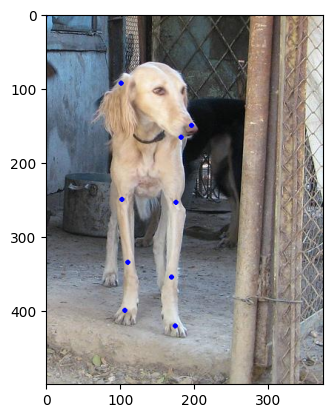

In [138]:
path = X_train[20]
draw_key_points(path);

img = cv.imread(path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
kp = json_dict[path]['joints']
# print(kp)
tf_img = tf.expand_dims(tf.image.resize(img, [args.image_size, args.image_size]), 0)
# preds = model.predict(tf_img) * args.image_size
# outs = np.reshape(preds, (24, 2))
# # print(outs)
hm = model.predict(tf_img) * args.image_size
# points = np.reshape(points, (24, 2))
# proba = np.round(proba).squeeze()

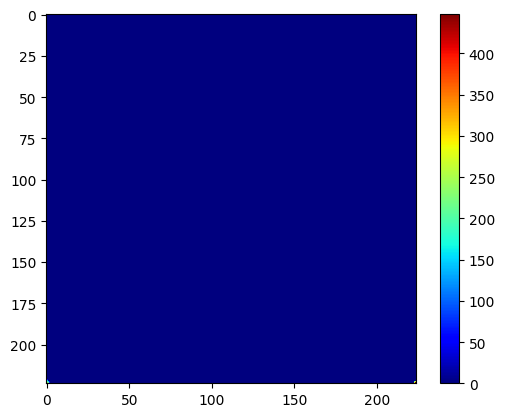

In [139]:
plt.imshow(np.sum(hm.squeeze(), axis=-1), cmap='jet')
plt.colorbar()
plt.show()

In [140]:
def extract_keypoints_from_heatmaps(heatmaps):
    keypoints = []
    for i in range(heatmaps.shape[-1]):
        channel = heatmaps[:, :, i]
        y, x = np.unravel_index(np.argmax(channel), channel.shape)
        keypoints.append((x, y))
    return keypoints

keypoints = extract_keypoints_from_heatmaps(hm.squeeze())
print(keypoints)

[(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (223, 223), (0, 0), (223, 223), (0, 0), (1, 0), (0, 0), (0, 222), (0, 0), (0, 0), (0, 223), (1, 223), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0)]


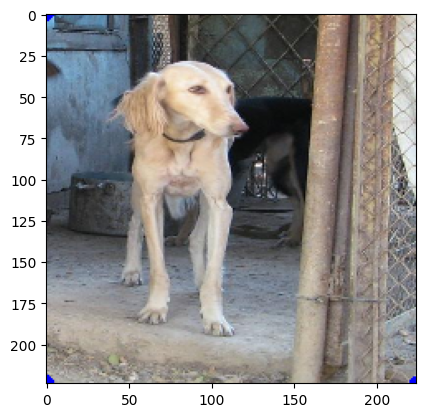

In [141]:
kp = keypoints
img = cv.resize(img, (224, 224),)
for p in kp:
    x,y = int(p[0]), int(p[1])
    cv.circle(img, (x,y), 2, (0,0,255), 2)

plt.imshow(img)